In [ ]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9

import liesel_ptm as ptm
import liesel_ptm.gam as gam

In [2]:
from pathlib import Path

import dill as pickle

with open(Path.cwd() / ".." / "notebooks" / "y_ridge.pkl", "rb") as fp:
    y = pickle.load(fp)

In [5]:
x = jax.random.uniform(jax.random.key(0), y.shape)

In [6]:
model = ptm.LocScalePTM.new_gaussian(y)


model.loc += gam.term.f(gam.lin(x, xname="x"))

model.build()

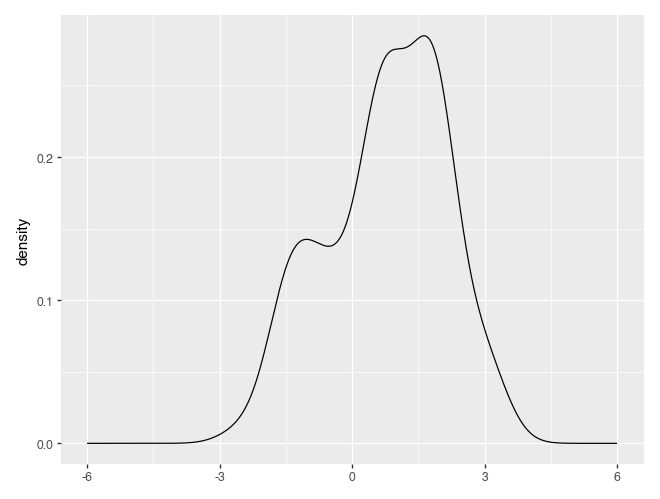

In [7]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_density(p9.aes(r_sample)) + p9.xlim((-6.0, 6.0)))

In [8]:
results = model.run_mcmc(seed=2, warmup=1000, posterior=1000)

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 250 transitions, 25 jitted together
100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.04chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1211.88chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1573.55chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
100%|████████████████████████████████████████| 4

In [9]:
gs.Summary(results)

,,kernel,mean,sd,q_0.05,q_0.5,q_0.95,sample_size,ess_bulk,ess_tail,rhat
parameter,index,,,,,,,,,,
$\beta_0$,(),kernel_02,0.941383,0.297941,0.456150,0.938068,1.433146,4000,223.099820,490.490164,1.019633
$\beta_{f(x)}$,"(0,)",kernel_01,-0.327233,0.503653,-1.170008,-0.328802,0.505345,4000,248.866014,395.652903,1.018189
$\gamma_0$,(),kernel_00,0.299193,0.070190,0.187287,0.297788,0.415321,4000,1906.814230,2585.313915,1.001148


In [10]:
samples = results.get_posterior_samples()

arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)


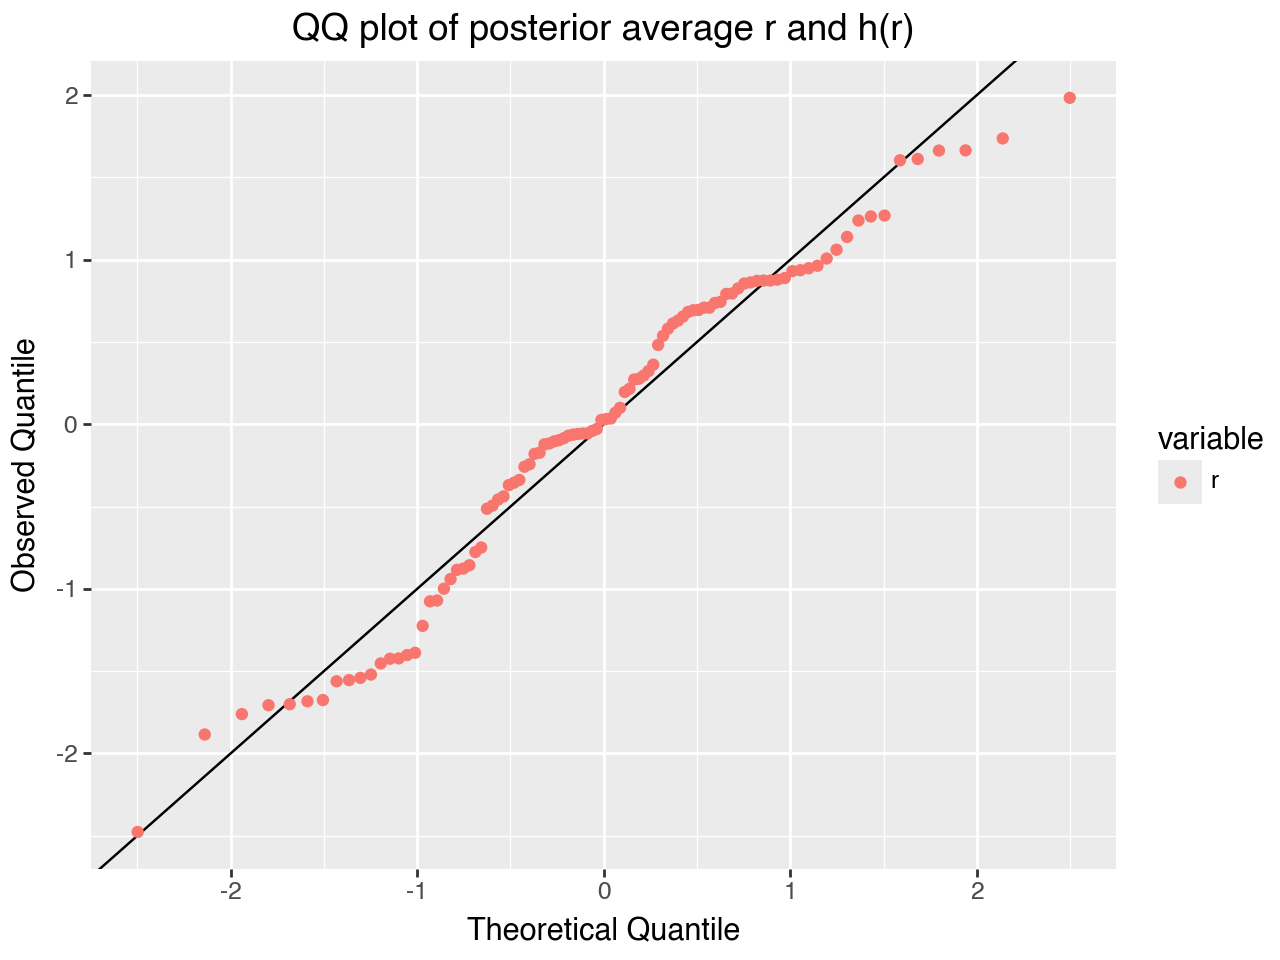

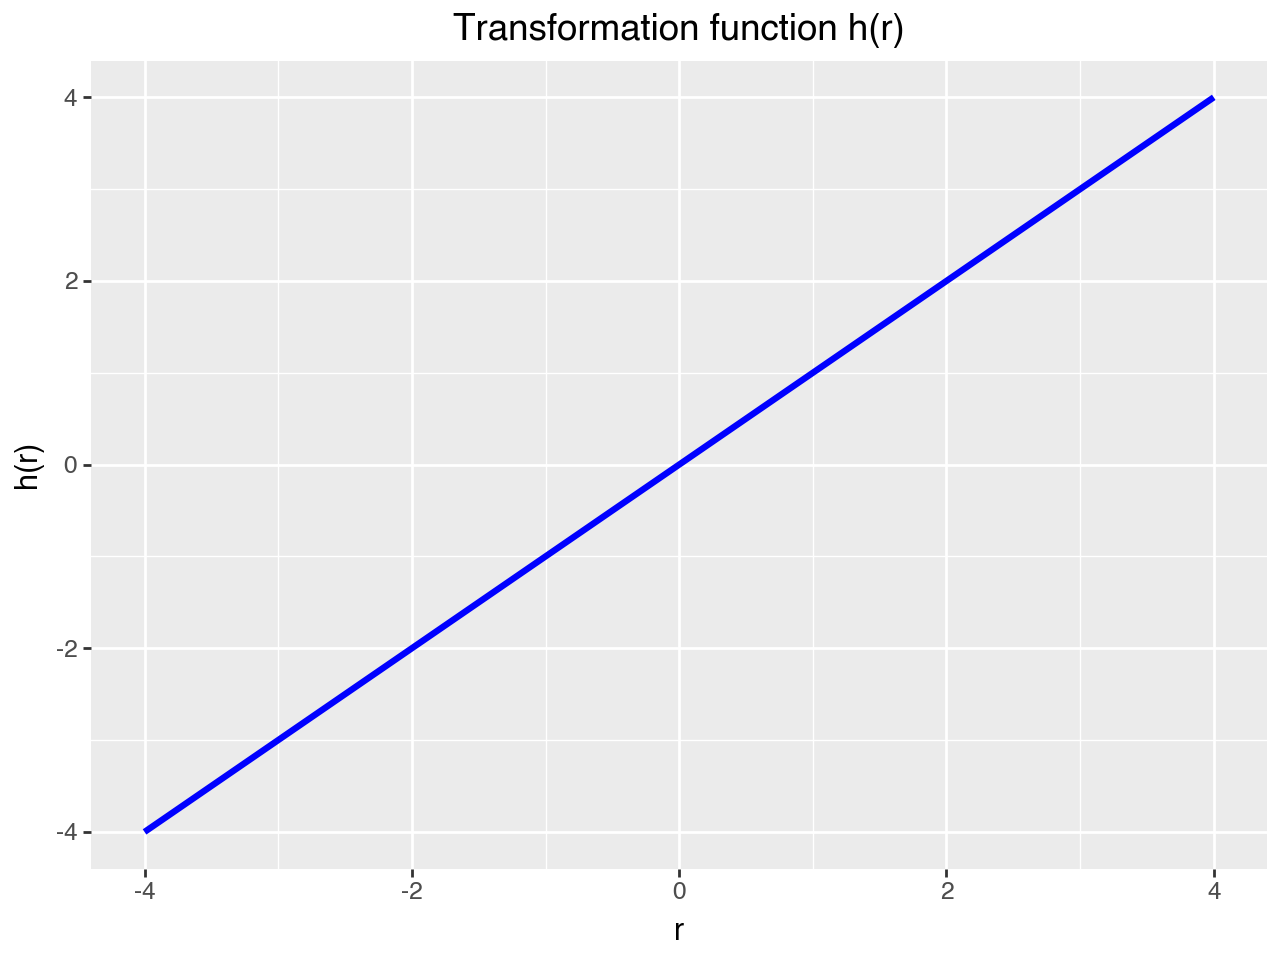

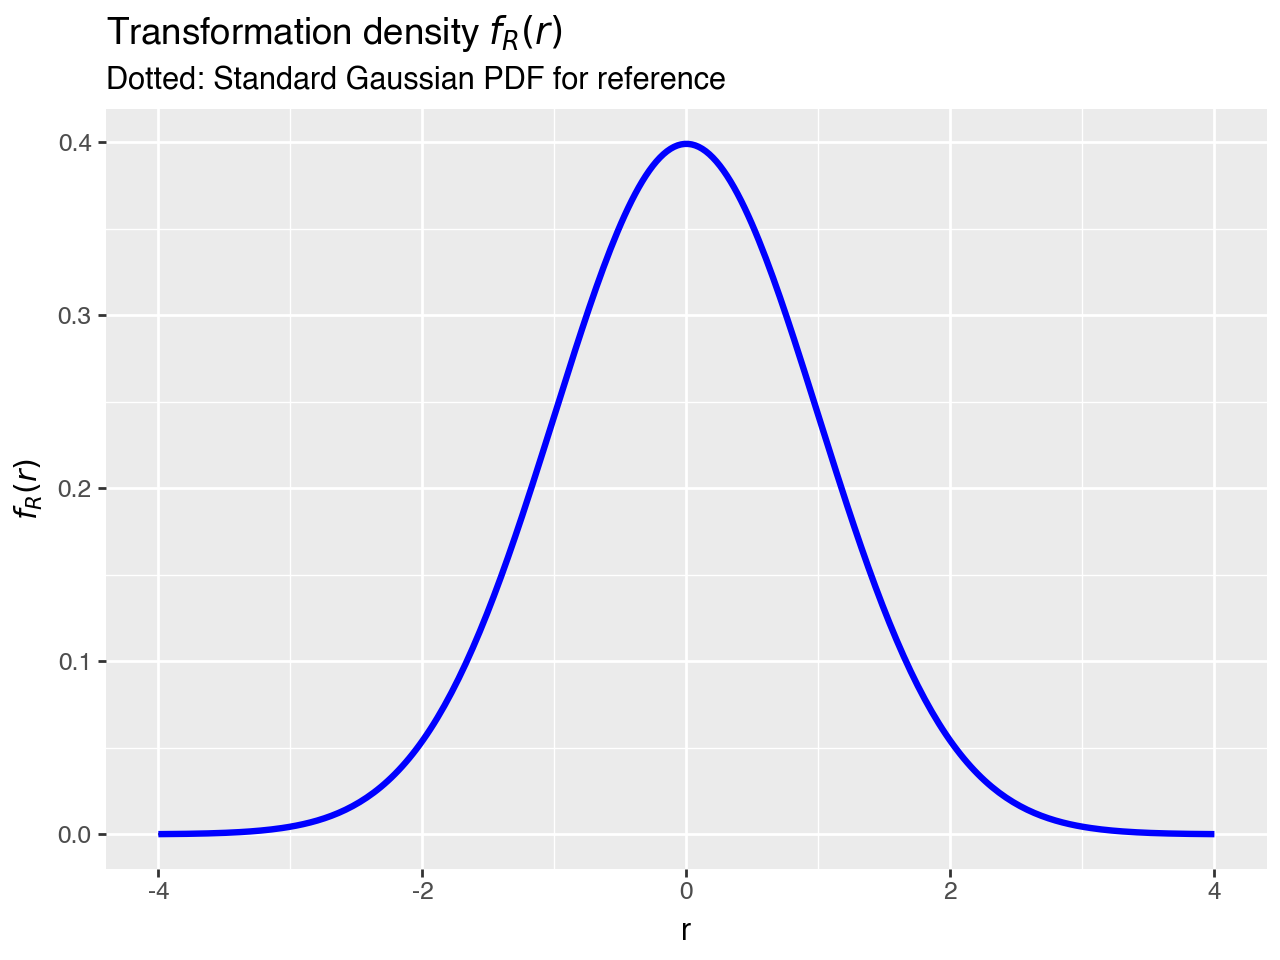

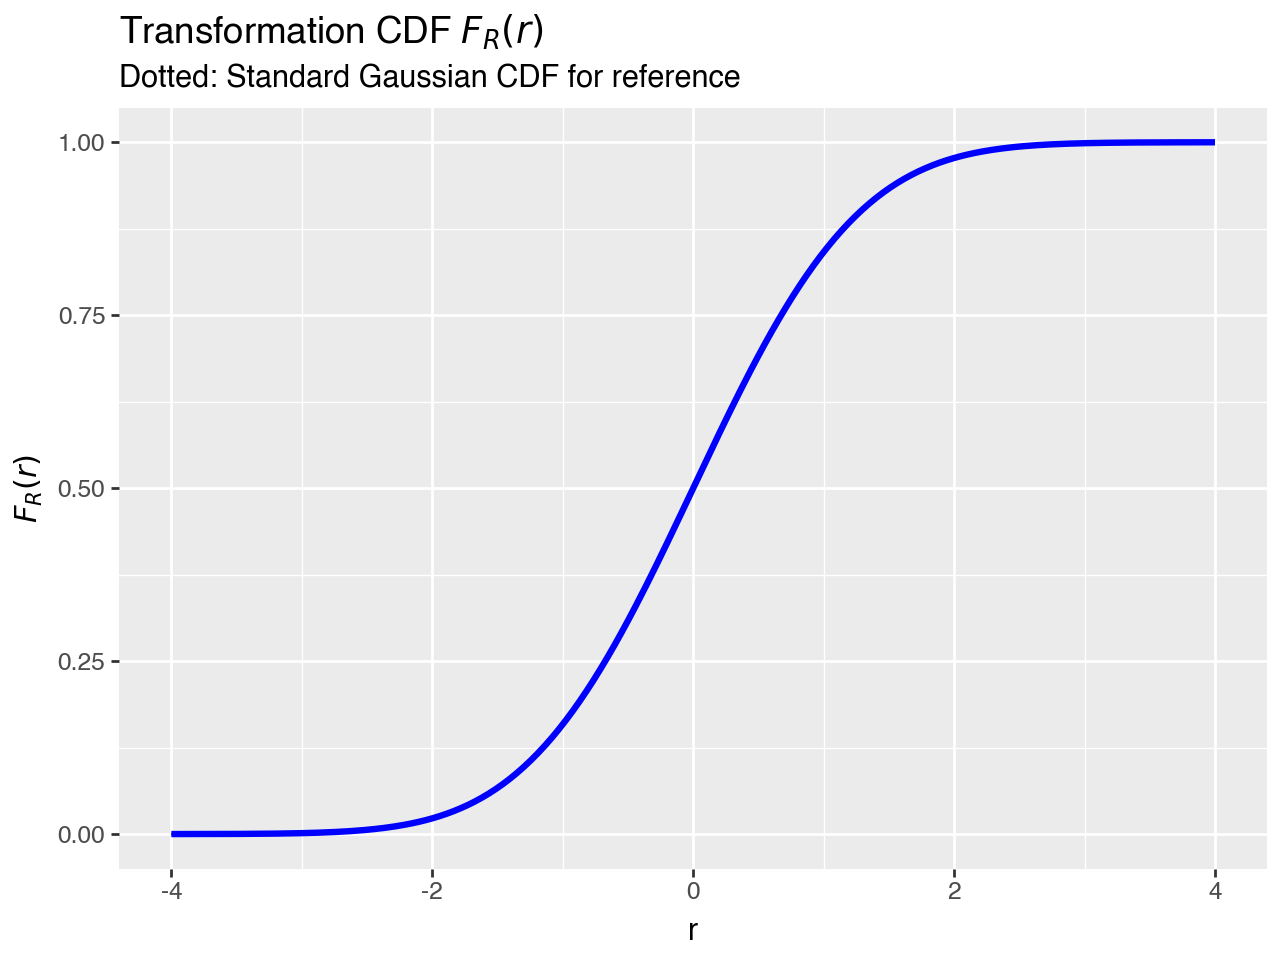

(<plotnine.ggplot.ggplot at 0x13075fdf0>,
 <plotnine.ggplot.ggplot at 0x130b54670>)

In [11]:
model.plot(samples)

In [12]:
dist = model.init_dist(samples, loc=0.0, scale=1.0)
rgrid = jnp.linspace(-6.0, 6.0, 301)
probs = jnp.exp(dist.log_prob(rgrid))
z = dist.transformation_and_logdet(rgrid)[0]

In [13]:
probs = jnp.expand_dims(probs, (0, 1))

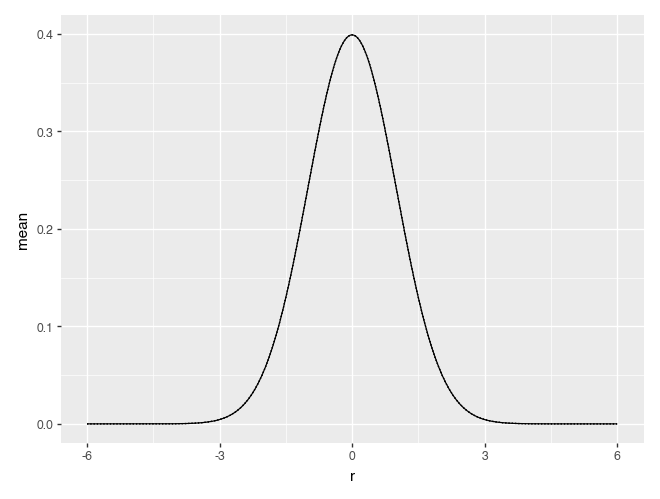

In [14]:
pdf_summary = gs.SamplesSummary({"pdf": probs}).to_dataframe().reset_index()
pdf_summary["r"] = rgrid

(
    p9.ggplot(pdf_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="red", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
)

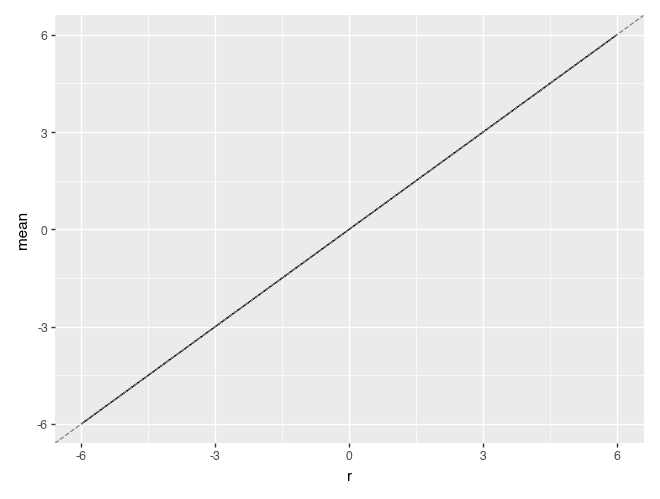

In [15]:
z = jnp.expand_dims(z, (0, 1))
z_summary = gs.SamplesSummary({"z": z}).to_dataframe().reset_index()
z_summary["r"] = rgrid

(
    p9.ggplot(z_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="blue", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
    + p9.geom_abline(intercept=0.0, slope=1.0, linetype="dashed", color="grey")
)